Special thanks to Abraham Ybarra for the feature selection code.

This will be like Logistics Regression Model 3.

# Libraries and importing data

In [1]:
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd
import re
import pickle

### Visualization packages

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb

### Scikit learn for Decision Tree

In [3]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, RFE, RFECV
from sklearn.feature_selection import RFE

Import below contained functions used in the class frequenctly.

In [4]:
import info5604_utils as util

### Importing the data. Dataset is multileveled so it needs to be imported this way

Display more columns

In [5]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', None)

In [6]:
df = pd.read_csv('../clean_data/data.csv', header=[0,1,2],index_col=[0])
print(df.shape)
df.head()

(7566, 104)


Info                       \
                                             MatchID                        
                                             Address League  Year  Season   
0  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
1  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
2  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
3  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
4  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   

                                        Blue                        \
                            BlueTag      Top                Jungle   
     Type gamelength Winner TeamTag      Top  TopChamp      Jungle   
0  Season         40   Blue     TSM    Dyrus    Irelia    Santorin   
1  Season         38    Red     CST     Cris      Gnar     Impaler   
2  Season         40   Blue     WFX  Flaresz  Renekton  ShorterACE   
3  Season         41    Red     TIP     Rhux    Irelia        Rush   
4  Season         35   Blue     CLG    Benny      Gnar     Xmithie   

                                                                        \
                    Middle                     ADC             Support   
  JungleChamp       Middle MiddleChamp         ADC  ADCChamp   Support   
0      RekSai     Bjergsen        Ahri  WildTurtle      Jinx   Lustboy   
1      Rengar        Jesiz        Ahri        Mash   Caitlyn     Sheep   
2      Rengar     Pobelter        Fizz       Altec     Sivir     Gleeb   
3    JarvanIV  XiaoWeiXiao     Leblanc      Apollo     Sivir    Adrian   
4    JarvanIV         Link   Lissandra  Doublelift  Tristana  aphromoo   

                  Info          Red                                     \
                RedTag          Top                 Jungle               
  SupportChamp TeamTag          Top TopChamp        Jungle JungleChamp   
0        Janna      C9        Balls     Gnar        Meteos       Elise   
1        Leona     DIG        Gamsu   Irelia       Crumbzz    JarvanIV   
2        Annie      GV     Hauntzer     Sion  Saintvicious      LeeSin   
3       Thresh      TL         Quas     Gnar    IWDominate        Nunu   
4        Janna      T8  CaliTrlolz8     Sion     Porpoise8      RekSai   

                                                                          \
     Middle                       ADC               Support                
     Middle MiddleChamp           ADC ADCChamp      Support SupportChamp   
0       Hai        Fizz        Sneaky    Sivir  LemonNation       Thresh   
1  Shiphtur        Azir        CoreJJ    Corki      KiWiKiD        Annie   
2     Keane        Azir           Cop    Corki   BunnyFuFuu        Janna   
3     Fenix        Lulu         KEITH   KogMaw      Xpecial        Janna   
4  Slooshi8        Lulu  Maplestreet8    Corki        Dodo8        Annie   

    Info                     Blue                      Red                  \
    diff                 TeamGold                 TeamGold                   
  Gold_5 Gold_10 Gold_15   Gold_5 Gold_10 Gold_15   Gold_5 Gold_10 Gold_15   
0   -268    -625    -790     5068   11361   18324     5336   11986   19114   
1    147    -242    1394     5511   11419   19698     5364   11661   18304   
2     34     913    2922     4933   12374   21237     4899   11461   18315   
3    228      16    -335     5398   12033   19332     5170   12017   19667   
4    113     205    -574     5404   11943   19426     5291   11738   20000   

    Blue                                                                       \
     Top                 Jungle                 Middle                    ADC   
  Gold_5 Gold_10 Gold_15 Gold_5 Gold_10 Gold_15 Gold_5 Gold_10 Gold_15 Gold_5   
0    893    2051    3630   1049    2486    3632   1102    2663    4608   1127   
1   1127    2406    4594   1176    2350    3929   1102    2547    4549   1182   
2    828    2419    4187   1041    2552    40

In [7]:
info = df['Info'].copy()
info.columns = [['Info', 'Info', 'Info', 'Info', 'Info', 'Info', 
                'Info', 'Blue', 'Red', 'Diff', 'Diff', 'Diff'],
                ['Address','League','Year','Season','Type','gamelength',
                'Winner','TeamTag','TeamTag','Gold_5', 'Gold_10', 'Gold_15']]

blue = df['Blue'].copy()
blue['Info','Team'] = 'Blue'
blue = pd.concat([info,blue],axis = 1)

red = df['Red'].copy()
red['Info','Team'] = 'Red'
red = pd.concat([info,red],axis =1)

In [8]:
df = pd.concat([blue,red],axis = 0,ignore_index = True)

In [9]:
y = df['Info','Winner']
X = df.drop(['Winner','Address'],level = 1,axis=1)

Creating the Training, Validation, and Testing sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2023, stratify=y)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023, stratify=y_train)

# Decision Tree

Creating the model and the pipeline to search for the optimal parameters

In [12]:
model = DecisionTreeClassifier(random_state=2023)

In [13]:
CATEGORICAL_VARS=[(      'Info',       'League'),
            (      'Info',         'Year'),
            (      'Info',       'Season'),
            (      'Info',         'Type'),
            (      'Blue',      'TeamTag'),
            (      'Red',      'TeamTag'),
            (       'Top',          'Top'),
            (       'Top',     'TopChamp'),
            (    'Jungle',       'Jungle'),
            (    'Jungle',  'JungleChamp'),
            (    'Middle',       'Middle'),
            (    'Middle',  'MiddleChamp'),
            (       'ADC',          'ADC'),
            (       'ADC',     'ADCChamp'),
            (   'Support',      'Support'),
            (   'Support', 'SupportChamp'),
            (      'Bans',        'ban_1'),
            (      'Bans',        'ban_2'),
            (      'Bans',        'ban_3'),
            (      'Bans',        'ban_4'),
            (      'Bans',        'ban_5'),
            (      'Info',         'Team')
                 ]

NUMERIC_VARS=[(      'Info',   'gamelength'),
            (      'Diff',       'Gold_5'),
            (      'Diff',      'Gold_10'),
            (      'Diff',      'Gold_15'),
            (  'TeamGold',       'Gold_5'),
            (  'TeamGold',      'Gold_10'),
            (  'TeamGold',      'Gold_15'),
            (       'Top',       'Gold_5'),
            (       'Top',      'Gold_10'),
            (       'Top',      'Gold_15'),
            (    'Jungle',       'Gold_5'),
            (    'Jungle',      'Gold_10'),
            (    'Jungle',      'Gold_15'),
            (    'Middle',       'Gold_5'),
            (    'Middle',      'Gold_10'),
            (    'Middle',      'Gold_15'),
            (       'ADC',       'Gold_5'),
            (       'ADC',      'Gold_10'),
            (       'ADC',      'Gold_15'),
            (   'Support',       'Gold_5'),
            (   'Support',      'Gold_10'),
            (   'Support',      'Gold_15'),
            ('Structures',       'Towers'),
            ('Structures',        'Inhib'),
            (  'Monsters',       'Dragon'),
            (    'Middle',        'Kills'),
            (    'Middle',       'Assist'),
            (       'Top',        'Kills'),
            (       'Top',       'Assist'),
            (       'ADC',        'Kills'),
            (       'ADC',       'Assist'),
            (   'Support',        'Kills'),
            (   'Support',       'Assist'),
            (    'Jungle',        'Kills'),
            (    'Jungle',       'Assist'),
                ]

columns=ColumnTransformer([('category',OneHotEncoder(drop='first',handle_unknown='ignore'),CATEGORICAL_VARS),
('numeric',MinMaxScaler(),NUMERIC_VARS)],remainder='drop')

In [14]:
selector = SelectKBest(score_func=chi2, k=20)

In [15]:
data_pipe = Pipeline(steps=[('preprocess', columns), ('filter', selector)])

In [16]:
pipe = Pipeline(steps=[('data',data_pipe), ('model', model)])

Grid Search and plot of the accuracies to examine best parameters to set the model as.

In [17]:
param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3,4,5,6,7,8],
    'model__min_samples_leaf': [2,3,4]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=skf, verbose=2)

In [18]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.5s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.6s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.5s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2023, shuffle=True),
             estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('preprocess',
                                                         ColumnTransformer(transformers=[('category',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'),
                                                                                          [('Info',
                                                                                            'League'),
                                                                                           ('Info',
                                                                                            'Year'),
                                                                                           ('Info',
                                                                                            'Season'),
                                                                                           ('Info',
                                                                                            'Type'),
                                                                                           ('Blue',
                                                                                            'TeamTag'),
                                                                                           ('Red',
                                                                                            'TeamTag'),
                                                                                           ('Top',
                                                                                            'T...
                                                                                           ('Middle',
                                                                                            'Kills'),
                                                                                           ('Middle',
                                                                                            'Assist'),
                                                                                           ('Top',
                                                                                            'Kills'),
                                                                                           ('Top',
                                                                                            'Assist'),
                                                                                           ('ADC',
                                                                                            'Kills'), ...])])),
                                                        ('filter',
                                                         SelectKBest(k=20,
                                                                     score_func=<function chi2 at 0x000001C996813160>))])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=2023))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 4, 5, 6, 7, 8],
                         'model__min_samples_leaf': [2, 3, 4]},
             verbose=2)

In [19]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']
rows = [dict(param_dict, score=score) for param_dict, score in zip(params, scores)]

In [20]:
rows

[{'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 2,
  'score': 0.7165428455010516},
 {'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 3,
  'score': 0.7165428455010516},
 {'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 4,
  'score': 0.7165428455010516},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 2,
  'score': 0.7226354868438456},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 3,
  'score': 0.7224289286064759},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 4,
  'score': 0.7222223703691062},
 {'model__criterion': 'gini',
  'model__max_depth': 5,
  'model__min_samples_leaf': 2,
  'score': 0.7248036816752497},
 {'model__criterion': 'gini',
  'model__max_depth': 5,
  'model__min_samples_leaf': 3,
  'score': 0.7243906185333885},
 {'model__criterion': 'gini',
  'model__max_dept

In [21]:
results_df = pd.DataFrame(rows)
results_df.columns = ['Criterion', 'Max Depth', 'Min Sample Leaf', 'Accuracy']
results_df

,Criterion,Max Depth,Min Sample Leaf,Accuracy
0,gini,3,2,0.716543
1,gini,3,3,0.716543
2,gini,3,4,0.716543
3,gini,4,2,0.722635
4,gini,4,3,0.722429
5,gini,4,4,0.722222
6,gini,5,2,0.724804
7,gini,5,3,0.724391
8,gini,5,4,0.723668
9,gini,6,2,0.726042


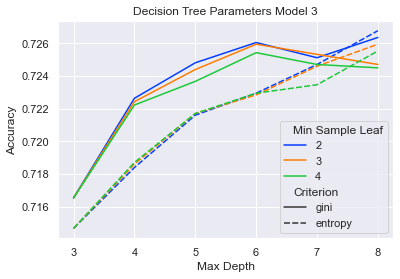

In [22]:
sb.set(rc={"figure.figsize":(10, 8)})
Grid_plot = sb.lineplot(data=results_df, x='Max Depth', y='Accuracy',
                           hue='Min Sample Leaf', style = 'Criterion', palette = 'bright')
Grid_plot.set(title = 'Decision Tree Parameters Model 3')
Grid_plot.get_figure().savefig('../plots/GridSearch_Decision_Tree_model_3.png', dpi=300, bbox_inches='tight')


Best model is:

$Max Depth = 8$

$Min Sample Leaf = 2$

$Criterion = Entropy$

In [23]:
model =  DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf = 2, random_state=2023)

In [24]:
pipe = Pipeline(steps=[('data',data_pipe), ('model', model)])

In [25]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('data',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(transformers=[('category',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   [('Info',
                                                                     'League'),
                                                                    ('Info',
                                                                     'Year'),
                                                                    ('Info',
                                                                     'Season'),
                                                                    ('Info',
                                                                     'Type'),
                                                                    ('Blue',
                                                                     'TeamTag'),
                                                                    ('Red',
                                                                     'TeamTag'),
                                                                    ('Top',
                                                                     'Top'),
                                                                    ('Top',
                                                                     'TopChamp'),
                                                                    ('Jungle',
                                                                     'Jungle'),
                                                                    ('Jungle',
                                                                     'JungleChamp'),
                                                                    ('Middle',
                                                                     'Middl...
                                                                     'Gold_15'),
                                                                    ('Structures',
                                                                     'Towers'),
                                                                    ('Structures',
                                                                     'Inhib'),
                                                                    ('Monsters',
                                                                     'Dragon'),
                                                                    ('Middle',
                                                                     'Kills'),
                                                                    ('Middle',
                                                                     'Assist'),
                                                                    ('Top',
                                                                     'Kills'),
                                                                    ('Top',
                                                                     'Assist'),
                                                                    ('ADC',
                                                                     'Kills'), ...])])),
                                 ('filter',
                                  SelectKBest(k=20,
                                              score_func=<function chi2 at 0x000001C996813160>))])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=8,
                                        min_samples_leaf=2,
                                        random_state=2023))])

In [26]:
DT_acc = util.print_accuracies(pipe, X_train, y_train, X_val, y_val)

Train accuracy 0.748	Test accuracy 0.718


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [27]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220914)

scores = cross_val_score(pipe, X_train, y_train, cv=skf)
SVM_scores = scores

C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 12, 14, 

([], [])

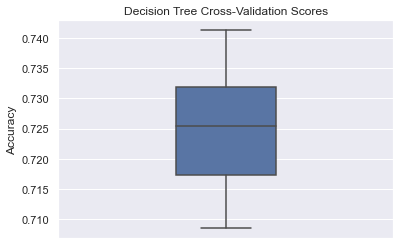

In [28]:
plot = sb.boxplot(data=scores, width=0.3)

plot.set(title = 'Decision Tree Cross-Validation Scores', ylabel='Accuracy')
plt.xticks([], [])

In [29]:
util.print_accuracies(pipe, X_train, y_train, X_val, y_val)

Train accuracy 0.748	Test accuracy 0.718


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[0.7481412639405205, 0.7182982238744321]

## Feature Selection

In [30]:
feature_names = pipe.named_steps['data'].get_feature_names_out()
feature_coefs = pipe.named_steps['model'].feature_importances_
feature_df = pd.DataFrame({'Feature Name': list(feature_names), 'Importance': list(feature_coefs.flatten())})
feature_df.sort_values(by='Importance', axis=0, ascending=False, inplace=True, ignore_index=True)
feature_df.head(20)

,Feature Name,Importance
0,numeric__x9,0.843943
1,numeric__x8,0.109212
2,category__x6_ahq,0.014504
3,category__x5_SKT,0.006771
4,category__x6_G2,0.005949
5,category__x6_SKT,0.004864
6,category__x5_TSM,0.003956
7,category__x5_TM,0.002978
8,category__x6_LYN,0.002901
9,category__x6_DFM,0.002543


In [31]:
X_cols = pd.DataFrame(X.columns, columns=['column'])
X_cols['column'] = X_cols['column'].astype(str)
X_cols['col'] = np.linspace(0, len(X.columns)-1, num=len(X.columns)).astype(int).astype(str)
X_cols = dict(zip(X_cols.col, X_cols.column))
X_cols

{'0': "('Info', 'League')",
 '1': "('Info', 'Year')",
 '2': "('Info', 'Season')",
 '3': "('Info', 'Type')",
 '4': "('Info', 'gamelength')",
 '5': "('Blue', 'TeamTag')",
 '6': "('Red', 'TeamTag')",
 '7': "('Diff', 'Gold_5')",
 '8': "('Diff', 'Gold_10')",
 '9': "('Diff', 'Gold_15')",
 '10': "('Top', 'Top')",
 '11': "('Top', 'TopChamp')",
 '12': "('Jungle', 'Jungle')",
 '13': "('Jungle', 'JungleChamp')",
 '14': "('Middle', 'Middle')",
 '15': "('Middle', 'MiddleChamp')",
 '16': "('ADC', 'ADC')",
 '17': "('ADC', 'ADCChamp')",
 '18': "('Support', 'Support')",
 '19': "('Support', 'SupportChamp')",
 '20': "('TeamGold', 'Gold_5')",
 '21': "('TeamGold', 'Gold_10')",
 '22': "('TeamGold', 'Gold_15')",
 '23': "('Top', 'Gold_5')",
 '24': "('Top', 'Gold_10')",
 '25': "('Top', 'Gold_15')",
 '26': "('Jungle', 'Gold_5')",
 '27': "('Jungle', 'Gold_10')",
 '28': "('Jungle', 'Gold_15')",
 '29': "('Middle', 'Gold_5')",
 '30': "('Middle', 'Gold_10')",
 '31': "('Middle', 'Gold_15')",
 '32': "('ADC', 'Gold_5')

In [32]:
list_of_chars=['\(', '\)', '\'']
pattern = '[' +  ''.join(list_of_chars) +  ']'
feature_df['Feature Name 2'] = [ re.sub(', ', '_', re.sub(pattern, '', re.sub('(.*)__x(\d+)',X_cols.get(re.search('x(\d+)', s).group(1)),s))) for s in feature_df['Feature Name']]
feature_df

,Feature Name,Importance,Feature Name 2
0,numeric__x9,0.843943,Diff_Gold_15
1,numeric__x8,0.109212,Diff_Gold_10
2,category__x6_ahq,0.014504,Red_TeamTag_ahq
3,category__x5_SKT,0.006771,Blue_TeamTag_SKT
4,category__x6_G2,0.005949,Red_TeamTag_G2
5,category__x6_SKT,0.004864,Red_TeamTag_SKT
6,category__x5_TSM,0.003956,Blue_TeamTag_TSM
7,category__x5_TM,0.002978,Blue_TeamTag_TM
8,category__x6_LYN,0.002901,Red_TeamTag_LYN
9,category__x6_DFM,0.002543,Red_TeamTag_DFM


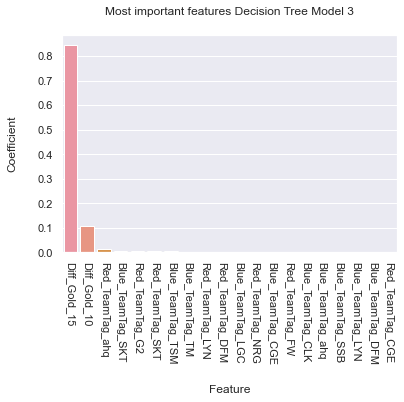

In [33]:
ax = sb.barplot(data=feature_df.iloc[0:20], x='Feature Name 2', y='Importance', orient='v')
ax.tick_params(axis='x', rotation=270)
ax.set_ylabel('Coefficient', rotation=90, labelpad=20)
ax.set_xlabel('Feature', rotation=0, labelpad=20)
ax.set_title('Most important features Decision Tree Model 3', pad=20)
plt.savefig('../plots/Coefs_DT_model_3.png',dpi=300, bbox_inches = "tight")

Saving model

In [34]:
with open("../Models/DT_model_3.pkl", "wb") as f:
    pickle.dump(model, f)